# OpenAI Gym

### Introduction to GYM

OpenAI Gym is an open source toolkit for reinforcement learning activities. The library of Gym is a collection of test problems - environments - that can be used to develop reinforcement learning algorithms. These environments have a shared interface, which allows you to write general algorithms.

Gym consists of a public Github repository with a diverse suite of environments ranging from easy to difficult and involving many different types of data.
- Classic control and toy text: complete small-scale tasks, mainly from RL literature
- Algorithmic: Performs calculations such as adding multi-digit numbers and reversing sequences
- Atari: Play classic Atari games
- 2D and 3D robots: control a robot in simulation <br/>

The main purpose of Gym is to provide a large collection of environments that exhibit a common interface making it possible to write generic algorithms that can be applied to many different environments.

In this Notebook we will test Policy Iteration, Value Iteration and Q-Learning algorithms on an OpenAI Gym environment, in particular Taxi Fuel

### CASE STUDY
The taxi's job is to pick up the passenger in one location and drop them off in another. There are some precautions to be taken into consideration: the taxi must leave the passenger in the right place and perform the fewest possible moves.

There are four designated positions in the grid world denoted by R (red), G (green), Y (yellow) and B (blue). When the episode begins, the taxi starts in a random position and the passenger is in a random position. The taxi drives to the passenger location, picks it up the passenger, drives to the passenger's destination (another of the four specified locations) and then leaves the passenger. Once the passenger is released, the episode ends.

There are 500 discrete states since there are 25 taxi positions, 5 possible passenger positions (including where the passenger is in the taxi) and 4 destination positions.

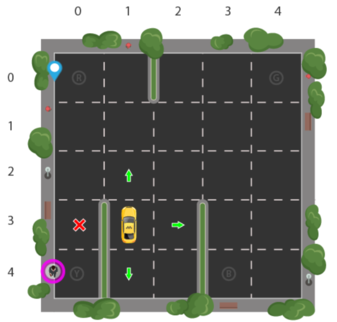

Passenger positions:                                               
   - 0: R
   - 1: G
   - 2: Y
   - 3: B
   - 4: by taxi
    
Destinations:
   - 0: R
   - 1: G
   - 2: Y
   - 3: B
    
Actions: There are 6 discrete deterministic actions: move south, north, east, west, passenger pick-up and passenger drop-off

Rewards: There is a default step reward of -1, except for delivering the passenger, which is +20 or illegally performing "pickup" and "drop-off" actions, which is -10.

In [1]:
import numpy as np
import gym
import time
import random

Support function to print the environment with the sequence of actions defined by the optimal policy (printed 200 frames)

In [2]:
def play_episodes(enviorment, n_episodes, policy, random = False):
    """
    This fucntion plays the given number of episodes given by following a policy or sample randomly from action_space.
    
    Parameters:
        enviorment: openAI GYM object
        n_episodes: number of episodes to run
        policy: Policy to follow while playing an episode
        random: Flag for taking random actions. if True no policy would be followed and action will be taken randomly
        
    Return:
        wins: Total number of wins playing n_episodes
        total_reward: Total reward of n_episodes
        avg_reward: Average reward of n_episodes
    
    """
    # intialize wins and total reward
    wins = 0
    total_reward = 0
    
    # loop over number of episodes to play
    for episode in range(n_episodes):
        
        # flag to check if the game is finished
        terminated = False
        
        # reset the enviorment every time when playing a new episode
        state = enviorment.reset()
        
        while not terminated:
            
            # check if the random flag is not true then follow the given policy other wise take random action
            if random:
                action = enviorment.action_space.sample()
            else:
                action = policy[state]

            # take the next step
            next_state, reward,  terminated, info = enviorment.step(action)
            
            enviorment.render()
            
            # accumalate total reward
            total_reward += reward
            
            # change the state
            state = next_state
            
            # if game is over with positive reward then add 1.0 in wins
            if terminated and reward == 1.0:
                wins += 1
                
    # calculate average reward
    average_reward = total_reward / n_episodes
    
    return wins, total_reward, average_reward

## VALUE ITERATION

### Helper function to  calculate state-value function

Arguments:
- env: openAI GYM Enviorment object
- state: state to consider
- V: Estimated Value for each state. Vector of length nS
- discount_factor: MDP discount factor

Return:
- action_values: Expected value of each action in a state. Vector of length nA

In [3]:
def one_step_lookahead(env, state, V, discount_factor = 0.99):

    # initialize vector of action values
    action_values = np.zeros(env.nA)

    # loop over the actions we can take in an enviorment
    for action in range(env.nA):
        # loop over the P_sa distribution.
        for probablity, next_state, reward, info in env.P[state][action]:
             #if we are in state s and take action a. then sum over all the possible states we can land into.
            action_values[action] += probablity * (reward + (discount_factor * V[next_state]))

    return action_values

### Helper function to update a given policy based on given value function.

Arguments:
- env: openAI GYM Enviorment object.
- policy: policy to update.
- V: Estimated Value for each state. Vector of length nS.
- discount_factor: MDP discount factor.

Return:
- policy: Updated policy based on the given state-Value function 'V'.

In [4]:
def update_policy(env, policy, V, discount_factor):

    for state in range(env.nS):
        # for a given state compute state-action value.
        action_values = one_step_lookahead(env, state, V, discount_factor)

        # choose the action which maximizez the state-action value.
        policy[state] =  np.argmax(action_values)

    return policy

### Algorithm to solve MPD.

Arguments:
- env: openAI GYM Enviorment object.
- discount_factor: MDP discount factor.
- max_iteration: Maximum No.  of iterations to run.

Return:
- V: Optimal state-Value function. Vector of lenth nS.
- optimal_policy: Optimal policy. Vector of length nS.

In [5]:
def value_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    
    # intialize value function
    V = np.zeros(env.nS)

    # iterate over max_iterations
    for i in range(max_iteration):

        #  keep track of change with previous value function
        prev_v = np.copy(V)

        # loop over all states
        for state in range(env.nS):

            # Synchronously update the state-action value
            action_values = one_step_lookahead(env, state, prev_v, discount_factor)

            # select best action to perform based on highest state-action value
            best_action_value = np.max(action_values)

            # update the current state-value fucntion
            V[state] =  best_action_value

        # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            # if values of 'V' not changing after one iteration
            if (np.all(np.isclose(V, prev_v))):
                print('Value converged at iteration %d' %(i+1))
                break

    # intialize optimal policy
    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    # update the optimal polciy according to optimal value function 'V'
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)

    return V, optimal_policy

In [6]:
env_vi = gym.make('Taxi-v3')
V_vi, policy_vi = value_iteration(env_vi.env, discount_factor = 0.999, max_iteration = 1000)

print('Value function: ', np.round(V_vi, 2), "\n")
mean=np.mean(V_vi)
print("Expected return:", np.round(mean, 2), "\n")

print('Policy: ', '. '.join(map(str, policy_vi)))

Value function:  [6003.57 5919.91 5961.66 5926.47 5836.91 5919.91 5836.91 5864.09 5919.91
 5878.33 5961.66 5884.84 5857.6  5878.33 5857.6  5926.47 6010.21 5926.47
 5968.26 5940.76 5989.21 5905.63 5947.34 5919.91 5843.39 5926.47 5843.39
 5878.33 5905.63 5864.09 5947.34 5878.33 5864.09 5884.84 5864.09 5940.76
 6003.57 5940.76 5961.66 5947.34 5940.76 5857.6  5899.1  5864.09 5899.1
 5982.59 5899.1  5926.47 5899.1  5857.6  5940.76 5864.09 5878.33 5899.1
 5878.33 5947.34 5947.34 5989.21 5947.34 5961.66 5926.47 5843.39 5884.84
 5857.6  5905.63 5989.21 5905.63 5940.76 5884.84 5843.39 5926.47 5857.6
 5884.84 5905.63 5884.84 5961.66 5940.76 6003.57 5940.76 5968.26 5919.91
 5836.91 5878.33 5843.39 5919.91 6003.57 5919.91 5947.34 5878.33 5836.91
 5919.91 5843.39 5878.33 5899.1  5878.33 5947.34 5926.47 6010.21 5926.47
 5961.66 5989.21 5905.63 5947.34 5919.91 5843.39 5926.47 5843.39 5878.33
 5926.47 5884.84 5968.26 5899.1  5864.09 5884.84 5864.09 5940.76 6003.57
 5940.76 5982.59 5947.34 5982.59 5899

In [7]:
n_episode=1
wins, total_reward, avg_reward = play_episodes(env_vi, n_episode, policy_vi, random = False)
print("\nTotal_reward: ", total_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y|

## POLICY ITERATION

### Helper function to evaluate a policy.

Arguments:
- env: openAI GYM Enviorment object.
- env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
- policy: policy to evaluate.
- V: Estimated Value for each state. Vector of length nS.
- discount_factor: MDP discount factor.

Return:
- policy_value: Estimated value of each state following a given policy and state-value 'V'.

In [8]:
def policy_eval(env, policy, V, discount_factor):
    
    policy_value = np.zeros(env.nS)
    for state, action in enumerate(policy):
        for probablity, next_state, reward, info in env.P[state][action]:
            policy_value[state] += probablity * (reward + (discount_factor * V[next_state]))

    return policy_value

### Helper function to update a given policy based on given value function.

Arguments:
- env: openAI GYM Enviorment object.
- policy: policy to update.
- V: Estimated Value for each state. Vector of length nS.
- discount_factor: MDP discount factor.

Return:
- policy: Updated policy based on the given state-Value function 'V'.

In [9]:
def update_policy(env, policy, V, discount_factor):

    for state in range(env.nS):
        # for a given state compute state-action value.
        action_values = one_step_lookahead(env, state, V, discount_factor)

        # choose the action which maximizez the state-action value.
        policy[state] =  np.argmax(action_values)

    return policy

### Helper function to  calculate state-value function

Arguments:
- env: openAI GYM Enviorment object
- state: state to consider
- V: Estimated Value for each state. Vector of length nS
- discount_factor: MDP discount factor

Return:
- action_values: Expected value of each action in a state. Vector of length nA

In [10]:
def one_step_lookahead(env, state, V, discount_factor = 0.99):

    # initialize vector of action values
    action_values = np.zeros(env.nA)

    # loop over the actions we can take in an enviorment
    for action in range(env.nA):
        # loop over the P_sa distribution.
        for probablity, next_state, reward, info in env.P[state][action]:
             #if we are in state s and take action a. then sum over all the possible states we can land into.
            action_values[action] += probablity * (reward + (discount_factor * V[next_state]))

    return action_values

### Algorithm to solve MPD.

Arguments:
- env: openAI GYM Enviorment object.
- discount_factor: MDP discount factor.
- max_iteration: Maximum No.  of iterations to run.

Return:
- V: Optimal state-Value function. Vector of lenth nS.
- new_policy: Optimal policy. Vector of length nS.


In [11]:
def policy_iteration(env, discount_factor = 0.999, max_iteration = 1000):
    
    # intialize the state-Value function
    V = np.zeros(env.nS)

    # intialize a random policy
    policy = np.random.randint(0, 4, env.nS)
    policy_prev = np.copy(policy)

    for i in range(max_iteration):

        # evaluate given policy
        V = policy_eval(env, policy, V, discount_factor)

        # improve policy
        policy = update_policy(env, policy, V, discount_factor)
        
         # if policy not changed over 10 iterations it converged.
        if i % 10 == 0:
            if (np.all(np.equal(policy, policy_prev))):
                print('Policy converged at iteration %d' %(i+1))
                break
            policy_prev = np.copy(policy)

    return V, policy

In [12]:
env_pi = gym.make('Taxi-v3')
V_pi, policy_pi = policy_iteration(env_pi.env, discount_factor = 0.999, max_iteration = 10000)

print('Value function: ', np.round(V_pi, 2), "\n")
mean=np.mean(V_pi)
print("Expected return:", np.round(mean, 2), "\n")

print('Policy: ', '. '.join(map(str, policy_pi)))

Policy converged at iteration 31
Value function:  [279.78 196.12 237.86 196.34 113.12 196.12 113.12 133.97 196.12 154.53
 237.86 154.72 133.8  154.53 133.8  196.34 280.09 196.34 238.13 216.97
 259.09 175.51 217.22 196.12 113.26 196.34 113.26 154.53 175.51 133.97
 217.22 154.53 133.97 154.72 133.97 216.97 279.78 216.97 237.86 217.22
 216.97 133.8  175.3  133.97 175.3  258.8  175.3  196.34 175.3  133.8
 216.97 133.97 154.53 175.3  154.53 217.22 217.22 259.09 217.22 237.86
 196.34 113.26 154.72 133.8  175.51 259.09 175.51 216.97 154.72 113.26
 196.34 133.8  154.72 175.51 154.72 237.86 216.97 279.78 216.97 238.13
 196.12 113.12 154.53 113.26 196.12 279.78 196.12 217.22 154.53 113.12
 196.12 113.26 154.53 175.3  154.53 217.22 196.34 280.09 196.34 237.86
 259.09 175.51 217.22 196.12 113.26 196.34 113.26 154.53 196.34 154.72
 238.13 175.3  133.97 154.72 133.97 216.97 279.78 216.97 258.8  217.22
 258.8  175.3  216.97 175.51 133.8  216.97 133.8  154.72 196.12 154.53
 237.86 154.72 154.53 175.3 

In [13]:
n_episode=1
wins, total_reward, avg_reward = play_episodes(env_pi, n_episode, policy_pi, random = False)
print("\nTotal_reward: ", total_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y|

## Q-LEARNING

### Training the agent

In [14]:
env_ql = gym.make("Taxi-v3")

q_table = np.zeros([env_ql.observation_space.n, env_ql.action_space.n])

alpha = 0.1 #learning rate
lambda_ = 0.6 # discount
epsilon = 0.1

#Training the agent
for i in range(10000):
    state = env_ql.reset()
    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        if random.uniform(0,1) < epsilon:
            action = env_ql.action_space.sample() #explore action space

        else:
            action = np.argmax(q_table[state]) #exploit learned values

        next_state, reward, done, info = env_ql.step(action)
        old_value = q_table[state,action]
        next_max = np.max(q_table[next_state])
        new_value = (1-alpha)*old_value + alpha*(reward+lambda_*next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1

    if i%100==0:
        #clear_output(wait=True)
        wait=True

### Algorithm to solve MPD

In [15]:
total_epochs, total_penalties= 0, 0
episodes = 10000
policy_ql = np.zeros(env_ql.observation_space.n)

for _ in range(episodes):
    state = env_ql.reset()
    reward = 0
    done = False

    while not done:
        action = np.argmax(q_table[state])
        policy_ql[state] = action
        state, reward, done, info = env_ql.step(action)

print("Q-table:", np.round(q_table, 2), "\n")

converted_value = getattr(policy_ql, "tolist", lambda: value)()
policy_ql = [round(x) for x in converted_value]
print('Policy: ', '. '.join(map(str, policy_ql)))

Q-table: [[  0.     0.     0.     0.     0.     0.  ]
 [ -2.41  -2.35  -2.4   -2.34  -2.27 -10.18]
 [ -1.85  -1.49  -1.86  -1.53  -0.75  -9.32]
 ...
 [ -1.24   0.17  -1.2   -1.21  -2.83  -3.54]
 [ -2.06  -2.06  -2.07  -2.06  -2.87  -3.56]
 [ -0.2   -0.2    1.21  10.88  -1.    -1.32]] 

Policy:  0. 4. 4. 4. 3. 0. 1. 0. 0. 0. 0. 0. 2. 2. 1. 0. 5. 0. 0. 0. 0. 3. 3. 3. 1. 0. 0. 0. 3. 3. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 2. 2. 0. 0. 0. 0. 0. 3. 1. 0. 0. 0. 0. 0. 0. 3. 0. 1. 2. 0. 2. 2. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 3. 4. 0. 4. 4. 0. 0. 0. 3. 3. 0. 0. 0. 3. 5. 3. 0. 0. 1. 1. 1. 2. 0. 2. 1. 0. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 3. 3. 3. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 2. 0. 0. 0. 0. 2. 2. 1. 0. 0. 0. 0. 0. 0. 3. 0. 3. 2. 0. 2. 2. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 1. 0. 1. 1. 3. 2. 0. 0. 3. 0. 0. 0. 0. 1. 0. 3. 0. 1. 1. 1. 2. 0. 2. 2. 0. 0. 0. 0. 2. 2. 2. 0. 1. 2. 0. 2. 0. 1. 1. 1. 2. 0. 2. 2. 3. 3. 0. 3. 2. 2. 2.

In [16]:
n_episode = 1
wins, total_reward, avg_reward = play_episodes(env_ql, n_episode, policy_ql, random = False)
print("\nTotal_reward: ", total_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y

#### _References:_
_OpenAI https://openai.com/_ <br/>
_Value and policy iteration code https://github.com/waqasqammar/MDP-with-Value-Iteration-and-Policy-Iteration_ <br/>
_Q-learning code https://github.com/LearnDataSci/article-resources/tree/master/Intro%20to%20Reinforcement%20Q-Learning_ <br/>